In [1]:
# Подключаем необходимые библиотеки и делаем общие настройки
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

from sklearn.model_selection import train_test_split
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from external_functions import * 
from xgboost import XGBRanker

**1. Подготовка данных**

**1.1. Загрузка датасета по событиям**

In [2]:
# Загрузим данные из events.csv 
df_events = pd.read_csv('events.csv')
df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [3]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


**1.2. Выделение валидационного датасета**

In [4]:
# Упорядочим датасет по времени возникновения событий
df_events.sort_values(by='timestamp', inplace=True)

In [5]:
# Выделим последние 30% содытий, как валидационный датасет
df_work, df_valid = train_test_split(df_events, test_size=0.3, shuffle=False)
print('Размер рабочего датасета:', df_work.shape)
print('Размер валидационного датасета:', df_valid.shape)

Размер рабочего датасета: (1929270, 5)
Размер валидационного датасета: (826831, 5)


**1.3. Предобработка данных и генерация новых признаков**

In [6]:
# (1) Удалим дубликаты, если они есть
df_work.drop_duplicates(inplace=True)

In [7]:
# Статистика по датасету
print('Записей в рабочем датасете:', df_work.shape[0])
print('Уникальных пользователей:', df_work['visitorid'].nunique())
print('Уникальных товаров:', df_work['itemid'].nunique())

Записей в рабочем датасете: 1928979
Уникальных пользователей: 978921
Уникальных товаров: 200975


In [8]:
# (2) Преобразуем временной признак в долее удобный для дальнейшей обработки формат
df_work['timestamp'] = pd.to_datetime(df_work['timestamp'], unit='ms')

In [9]:
# (3) Удалим признак transactionid, как не информативный в нашем случае
df_work.drop(['transactionid'], axis=1, inplace=True)

In [10]:
# Обработаем признак events
df_work['event'].value_counts()

view           1866026
addtocart        47316
transaction      15637
Name: event, dtype: int64

In [11]:
# (4) Признак event сделаем бинарным: продажи и корзину - 1, просмотр - 0
event_dic = {'view':0, 'addtocart':1, 'transaction':1}
df_work['event'] = df_work['event'].apply(lambda x: event_dic[x])
df_work['event'].value_counts()

0    1866026
1      62953
Name: event, dtype: int64

In [12]:
df_work.head()

,timestamp,visitorid,event,itemid
1462974,2015-05-03 03:00:04.384,693516,1,297662
1464806,2015-05-03 03:00:11.289,829044,0,60987
1463000,2015-05-03 03:00:13.048,652699,0,252860
1465287,2015-05-03 03:00:24.154,1125936,0,33661
1462955,2015-05-03 03:00:26.228,693516,0,297662


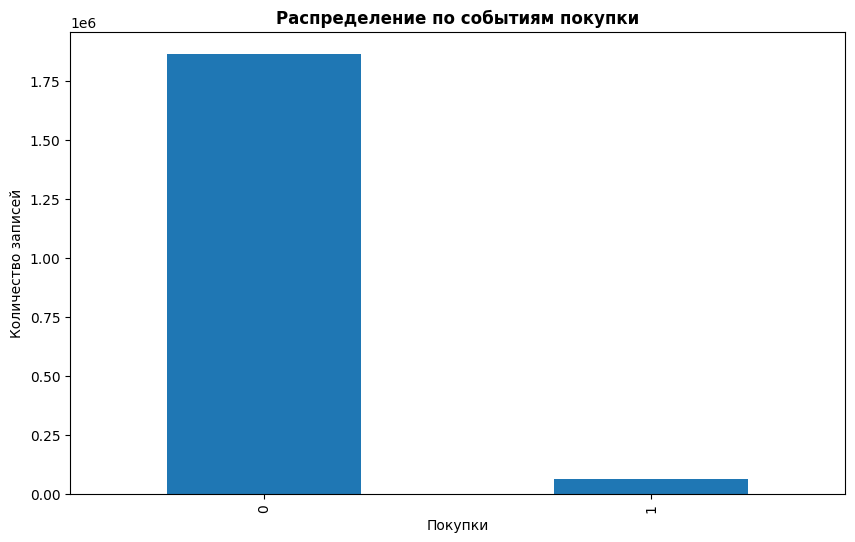

In [13]:
# Смотрим распределение событий-покупок в рабочем датасете
df_work['event'].value_counts().plot.bar(figsize=(10,6))
plt.title('Распределение по событиям покупки', fontweight='bold')
plt.xlabel('Покупки')
plt.ylabel('Количество записей')
plt.show()

Количество событий-покупок незначительно в общем количестве событий датасета. Это плохо, т.к. возможно сделать осмысленные рекомендации только для активных пользователей. Но будем исходить из того, что есть.

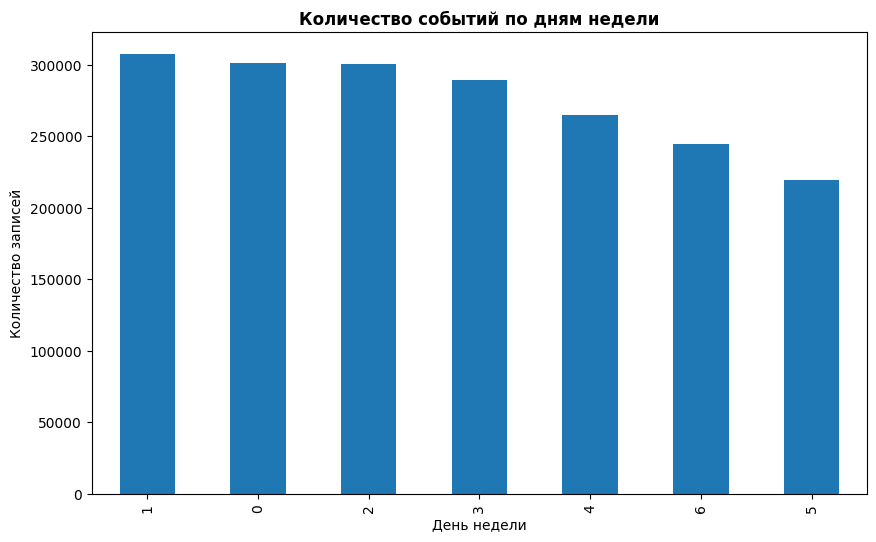

In [14]:
# Смотрим распределдение записей датасета по дням недели
df_work['timestamp'].dt.dayofweek.value_counts().plot.bar(figsize=(10,6))
plt.title('Количество событий по дням недели', fontweight='bold')
plt.xlabel('День недели')
plt.ylabel('Количество записей')
plt.show()

Из графика видно, что наибольшая активность пользователей проявляется в начале недели и незначительно падает к ее концу (Здесь, 0 - это понедельник).

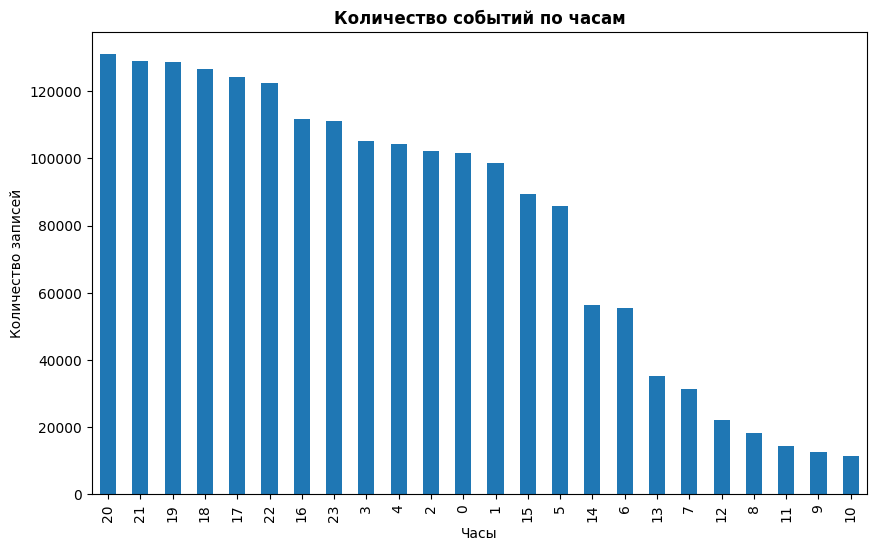

In [15]:
df_work['timestamp'].dt.hour.value_counts().plot.bar(figsize=(10,6))
plt.title('Количество событий по часам', fontweight='bold')
plt.xlabel('Часы')
plt.ylabel('Количество записей')
plt.show()

Наибольшая активность пользователей наблюдается с 15 часов и до 5 утра следующего дня. 

Используя выводы полученные из графиков приведенных выше сформируем новые временные признаки раздельно для пользователей и товаров.

In [16]:
# (5) Подготовим части датасета на основе временного штампа, для дальнейшего формирования из них train и test выборок для модели
start = min(df_work['timestamp'])
end = max(df_work['timestamp'])
interval = end - start

train = df_work[df_work['timestamp'] <= (end - interval/3)]
test = df_work[df_work['timestamp'] >= (start + interval/3)]

train_1 = train[train['timestamp'] < (start + interval/3)]
train_2 = train[train['timestamp'] >= (start + interval/3)]
test_1 = test[test['timestamp'] < (end - interval/3)]
test_2 = test[test['timestamp'] >= (end - interval/3)]

# Таргетированные группы пользователей для train и test выборок
train_target_user = set(train_1['visitorid']) & set(train_2['visitorid'])
test_target_user = set(test_1['visitorid']) & set(test_2['visitorid'])

print('train:', train['timestamp'].min(), '-', train['timestamp'].max())
print('test:', test['timestamp'].min(), '-', test['timestamp'].max())

train: 2015-05-03 03:00:04.384000 - 2015-07-03 08:40:14.732000
test: 2015-06-02 17:50:23.990000 - 2015-08-02 23:30:53.300000


In [17]:
# (6) Формируем выборки с новыми признаками для частей датасета раздельно по пользователям и товарам (1 час 15 мин)
train_1_u = new_feature_by_user(train_1)
test_1_u = new_feature_by_user(test_1)

train_1_i = new_feature_by_item(train_1)
test_1_i = new_feature_by_item(test_1)

100%|█████████████████████████████████████████████████████████████████████████| 118940/118940 [09:56<00:00, 199.35it/s]


In [18]:
# (7) Сформируем train и test выборки и таргетированные группы пользователей необходимые для передачи на вход модели
X_train, y_train, query_list_train = get_model_input(train_1_u, train_1_i, train_2, train_target_user)
X_test, y_test, query_list_test = get_model_input(test_1_u, test_1_i, test_2, test_target_user)

In [19]:
X_train

user_count  purchased_by_item  not_purchased_by_item  \
visitorid itemid                                                         
74.0      262125       103.0                0.0                  103.0   
197.0     144066         5.0                0.0                    5.0   
299.0     149253        64.0                4.0                   60.0   
          149253        64.0                4.0                   60.0   
          322067         0.0                0.0                    0.0   
...                      ...                ...                    ...   
1407374.0 444955         3.0                0.0                    3.0   
          459841         0.0                0.0                    0.0   
1407383.0 92637         17.0                0.0                   17.0   
          92637         17.0                0.0                   17.0   
          413556        21.0                0.0                   21.0   

                  monday_by_item  tuesday_by_item  wednesday_by_item  \
visitorid itemid                                                       
74.0      262125            18.0             25.0               14.0   
197.0     144066             0.0              2.0                0.0   
299.0     149253            16.0              5.0                2.0   
          149253            16.0              5.0                2.0   
          322067             0.0              0.0                0.0   
...                          ...              ...                ...   
1407374.0 444955             0.0              0.0                0.0   
          459841             0.0              0.0                0.0   
1407383.0 92637              5.0              2.0                0.0   
          92637              5.0              2.0                0.0   
          413556             2.0              2.0                4.0   

                  thursday_by_item  friday_by_item  saturday_by_item  \
visitorid itemid                                                       
74.0      262125              12.0            17.0               7.0   
197.0     144066               0.0             1.0               1.0   
299.0     149253               4.0             6.0               8.0   
          149253               4.0             6.0               8.0   
          322067               0.0             0.0               0.0   
...                            ...             ...               ...   
1407374.0 444955               1.0             0.0               0.0   
          459841               0.0             0.0               0.0   
1407383.0 92637                1.0             1.0               3.0   
          92637                1.0             1.0               3.0   
          413556               4.0             2.0               3.0   

                  sunday_by_item  ...  not_purchased_by_user  monday_by_user  \
visitorid itemid                  ...                                          
74.0      262125            10.0  ...                    5.0             0.0   
197.0     144066             1.0  ...                    1.0             0.0   
299.0     149253            23.0  ...                    1.0             0.0   
          149253            23.0  ...                    1.0             0.0   
          322067             0.0  ...                    1.0             0.0   
...                          ...  ...                    ...             ...   
1407374.0 444955             2.0  ...                    6.0             0.0   
          459841             0.0  ...                    6.0             0.0   
1407383.0 92637              5.0  ...                    1.0             0.0   
          92637              5.0  ...                    1.0             0.0   
          413556             4.0  ...                    1.0             0.0   

                  tuesday_by_user  wednesday_by_user  thursday_by_user  \
visitorid itemid                                                  

In [20]:
y_train

visitorid  itemid
74.0       262125    0.0
197.0      144066    0.0
299.0      149253    0.0
           149253    1.0
           322067    0.0
                    ... 
1407374.0  444955    0.0
           459841    0.0
1407383.0  92637     0.0
           92637     0.0
           413556    0.0
Name: event, Length: 65916, dtype: float64

In [21]:
query_list_train

74.0          1
197.0         1
299.0         4
341.0         1
502.0         1
             ..
1407072.0     2
1407134.0     1
1407340.0    21
1407374.0     7
1407383.0     3
Name: visitorid, Length: 15315, dtype: int64

**1.4. Работа с моделью XGBRanker**

In [22]:
# Создадим объект модели и обучим его экземпляр
model = XGBRanker(objective='rank:ndcg', n_estimators=200, random_state=42, learning_rate=0.1)
model.fit(
    X_train,
    y_train,
    group=query_list_train,
    eval_metric='ndcg',
    eval_set=[(X_test, y_test)],
    eval_group=[list(query_list_test)],
    verbose=10
)

[0]	validation_0-ndcg:0.98034
[10]	validation_0-ndcg:0.98055
[20]	validation_0-ndcg:0.98060
[30]	validation_0-ndcg:0.98060
[40]	validation_0-ndcg:0.98057
[50]	validation_0-ndcg:0.98052
[60]	validation_0-ndcg:0.98057
[70]	validation_0-ndcg:0.98058
[80]	validation_0-ndcg:0.98055
[90]	validation_0-ndcg:0.98054
[100]	validation_0-ndcg:0.98051
[110]	validation_0-ndcg:0.98042
[120]	validation_0-ndcg:0.98037
[130]	validation_0-ndcg:0.98047
[140]	validation_0-ndcg:0.98036
[150]	validation_0-ndcg:0.98049
[160]	validation_0-ndcg:0.98051
[170]	validation_0-ndcg:0.98050
[180]	validation_0-ndcg:0.98048
[190]	validation_0-ndcg:0.98051
[199]	validation_0-ndcg:0.98046


XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=None,
          enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.1, max_bin=256,
          max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
          min_child_weight=1, missing=nan, monotone_constraints='()',
          n_estimators=200, n_jobs=0, num_parallel_tree=1,
          objective='rank:ndcg', predictor='auto', random_state=42, reg_alpha=0, ...)

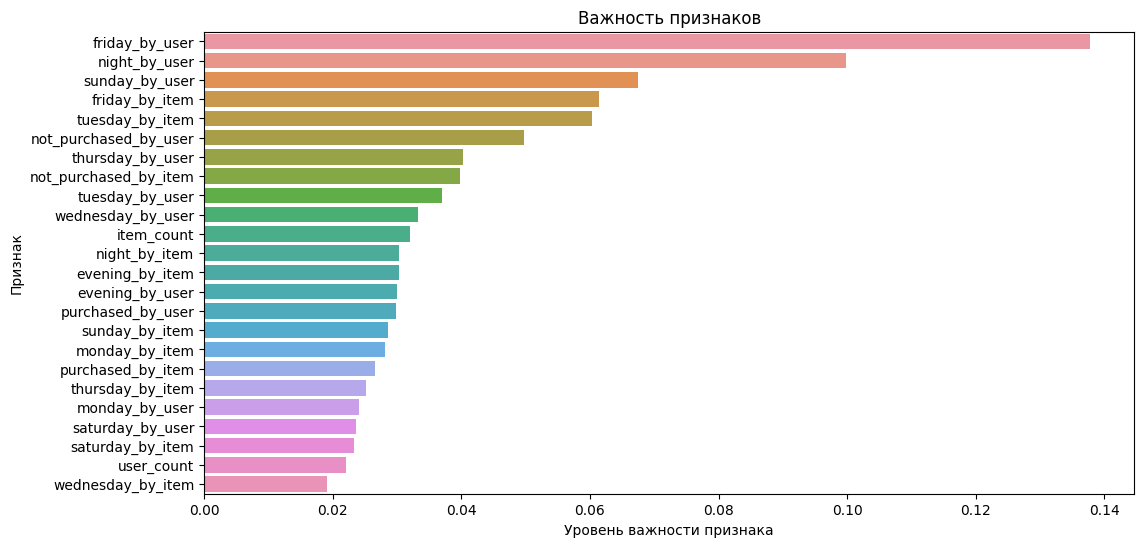

In [23]:
# Рассмотрим уровень важности признаков датасета полученной модели
plt.figure(figsize=(12, 6))
df_plt = pd.DataFrame({'feature_name': X_train.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x='feature_importance', y='feature_name', data=df_plt)
plt.title('Важность признаков')
plt.xlabel('Уровень важности признака')
plt.ylabel('Признак')
plt.show()

In [24]:
# Сохраним модель в файл, для использования в приложении
model.save_model('XGBRanker_model.json')

**1.5. Получение рекомендаций товаров и расчет технической метрики для тестовой выборки**

In [25]:
# Выделим Топ-3 товаров для добавления в итог рекомендаций, при недостаке значений в предсказании
top3_items = list(df_work[df_work['event'] == 1]['itemid'].value_counts().index[:3])
top3_items

[461686, 312728, 409804]

In [26]:
# Рекомендации для всех доступных модели пользователей трех товаров + расчет технической метрики (2 мин)
predicted, p_at_3_test = predict_at_3(model, X_test, y_test, top3_items)
predicted

100%|███████████████████████████████████████████████████████████████████████████| 15042/15042 [01:59<00:00, 125.55it/s]


,visitorid,itemid,rank
0,75.0,257575,1
1,75.0,257575,2
2,75.0,257575,3
3,124.0,354724,1
4,124.0,461686,2
...,...,...,...
45121,1407304.0,461686,2
45122,1407304.0,312728,3
45123,1407374.0,241201,1
45124,1407374.0,184173,2


In [27]:
# Пример предсказания для одиночного пользователя
userid = 1407374.0
print('Товары, предложенные пользователю', userid)
print(predicted[predicted['visitorid'] == userid][['itemid', 'rank']])

Товары, предложенные пользователю 1407374.0
       itemid  rank
45123  241201     1
45124  184173     2
45125  461686     3


In [28]:
print('Реальные действия пользователя', userid)
print(y_test[userid])

Реальные действия пользователя 1407374.0
itemid
184173    0.0
241201    0.0
Name: event, dtype: float64


Видно, что из предложенного моделью списка номенклатуры, пользователь реально просматривал товары с ID 184173, 241201, но, к сожалению, не приобрел их.

Функция для рекомендации трех товаров, одновременно производит расчет усредненной метрики Precision@3:

In [31]:
print('Precision@3 (test):', p_at_3_test)

Precision@3 (test): 0.0184815848956256


Итоговое значение метрики Precision@3 для тестовой части рабочей выборки - 1,85%.

**1.6. Расчет метрики Precision@3 на валидационном датасете**

Выполним те же действия по продготовке валидационного датасета, что мы делали с рабочим датасетом при подготовке к работе с моделью.

In [32]:
# (1) Удалим дубликаты, если они есть
df_valid.drop_duplicates(inplace=True)

In [33]:
# Статистика по датасету
print('Записей в рабочем датасете:', df_valid.shape[0])
print('Уникальных пользователей:', df_valid['visitorid'].nunique())
print('Уникальных товаров:', df_valid['itemid'].nunique())

Записей в рабочем датасете: 826662
Уникальных пользователей: 458523
Уникальных товаров: 140405


In [34]:
# (2) Преобразуем временной признак в долее удобный для дальнейшей обработки формат
df_valid['timestamp'] = pd.to_datetime(df_valid['timestamp'], unit='ms')

In [35]:
# (3) Удалим признак transactionid, как не информативный в нашем случае
df_valid.drop(['transactionid'], axis=1, inplace=True)

In [36]:
# (4) Обработаем признак events
event_dic = {'view':0, 'addtocart':1, 'transaction':1}
df_valid['event'] = df_valid['event'].apply(lambda x: event_dic[x])
df_valid['event'].value_counts()

0    798192
1     28470
Name: event, dtype: int64

In [37]:
df_valid.head()

,timestamp,visitorid,event,itemid
640597,2015-08-02 23:30:55.147,171351,0,219512
638818,2015-08-02 23:31:03.263,706829,0,213319
635437,2015-08-02 23:31:06.365,245823,1,413476
638995,2015-08-02 23:31:07.160,275399,0,277746
626922,2015-08-02 23:31:10.918,886927,0,276545


In [38]:
# (5) Подготовим части датасета на основе временного признака, для дальнейшего формирования из них valid выборок для модели
start = min(df_valid['timestamp'])
end = max(df_valid['timestamp'])
interval = end - start

valid_1 = df_valid[df_valid['timestamp'] < (end - interval/2)]
valid_2 = df_valid[df_valid['timestamp'] >= (end - interval/2)]

valid_target_user = set(valid_1['visitorid']) & set(valid_2['visitorid'])

In [39]:
# (6) Формируем выборки с новыми признаками для частей датасета раздельно по пользователям и товарам (1 ч 19 мин)
valid_1_u = new_feature_by_user(valid_1)
valid_1_i = new_feature_by_item(valid_1)

100%|████████████████████████████████████████████████████████████████████████████| 98007/98007 [19:15<00:00, 84.83it/s]


In [40]:
# (7) Сформируем valid выборки, необходимые для передачи на вход модели
X_valid, y_valid, query_list_valid = get_model_input(valid_1_u, valid_1_i, valid_2, valid_target_user)

In [41]:
# Сформируем рекомендации и расчитаем техническую метрику (~3 мин)
predicted, p_at_3_valid = predict_at_3(model, X_valid, y_valid, top3_items)
predicted

100%|██████████████████████████████████████████████████████████████████████████████| 9894/9894 [03:20<00:00, 49.38it/s]


,visitorid,itemid,rank
0,155.0,452082,1
1,155.0,442601,2
2,155.0,389974,3
3,425.0,87074,1
4,425.0,461686,2
...,...,...,...
29677,1407460.0,461686,2
29678,1407460.0,312728,3
29679,1407492.0,34251,1
29680,1407492.0,461686,2


In [44]:
# Пример предсказания для одиночного пользователя из валидационной выборки
userid = 1407460.0
print('Товары, предложенные пользователю', userid)
print(predicted[predicted['visitorid'] == userid][['itemid', 'rank']])

Товары, предложенные пользователю 1407460.0
       itemid  rank
29676   91093     1
29677  461686     2
29678  312728     3


In [46]:
print('Реальные действия пользователя', userid)
print(y_valid[userid])

Реальные действия пользователя 1407460.0
itemid
91093    0.0
Name: event, dtype: float64


In [47]:
# Вывод итогового значения технической выборки
print('Precision@3 (valid):', p_at_3_valid)

Precision@3 (valid): 0.015430227073647313


Итоговое значение метрики Precision@3 для валидационной выборки - 1,54%.